In [1]:
import pdb
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x): return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
class Value:
    
    def __init__(self, data, _children=(), _op = '', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)  # Why set? we believe it's for efficiency
        self._op = _op
        self.label = label
        
    def __repr__(self): return f'value(data={self.data})'
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        # Topological Sorting
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)   # Recursive algorithm
                topo.append(v)
        build_topo(self)
        self.grad = 1 # Setting the last node grad
        for node in reversed(topo):
            node._backward()

    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
    
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self): # -self
        return self * -1

    def __rmul__(self, other):
        return self * other
        
    def __radd__(self, other):
        return self + other
    
    def __truediv__(self, other): # self / other
        return self * other**-1

    def __sub__(self, other):
        return self + (-other)


In [5]:
a = Value(2.0)
a / 2

value(data=1.0)

In [6]:
a = Value(2.0)
#2 + a
b = Value(4.0)
a/b


value(data=0.5)

Implementing Division
- a/b
- a * (1/b)
- a * (b**-1)

In [7]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [8]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

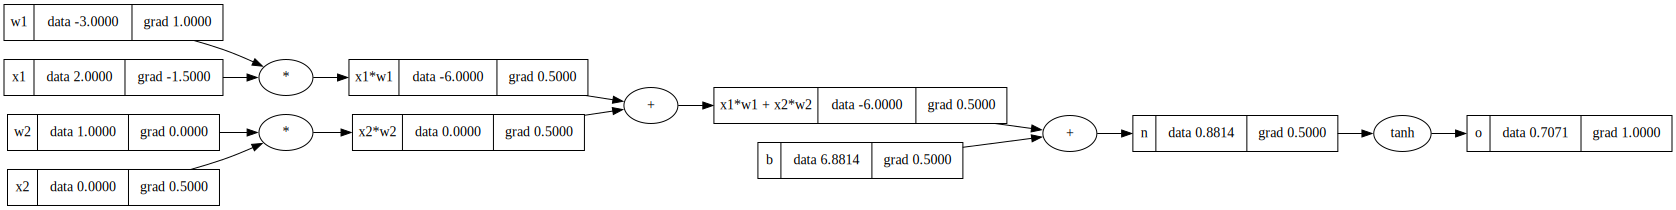

In [9]:
o.backward()
draw_dot(o)

In [10]:
import torch

In [11]:
x1 = torch.Tensor([2.0]).double()                     ; x1.requires_grad_()
x2 = torch.Tensor([0.0]).double()                      ; x2.requires_grad_()
w1 = torch.Tensor([-3.0]).double()                    ; w1.requires_grad_()
w2 = torch.Tensor([1.0]).double()                    ; w2.requires_grad_()
b  = torch.Tensor([6.881373587019543]).double()        ; b.requires_grad_()

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [12]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
  
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
  
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
  
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
  
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [13]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

value(data=-0.8833506261224605)

In [14]:
len(n.parameters()), n.parameters()[:5]

(41,
 [value(data=0.1390958214375082),
  value(data=-0.6784724497489409),
  value(data=-0.6574399894904459),
  value(data=0.9795033928818522),
  value(data=0.07338916111036498)])

In [15]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5,  1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

### Forward Pass

In [16]:
ypreds = [n(x) for x in xs]
loss = [((yout - ygt)**2) for ygt, yout in zip(ys, ypreds)]  # ygt is y ground truth

In [17]:
ypreds, loss

([value(data=-0.8833506261224605),
  value(data=-0.7373092413011715),
  value(data=-0.8974917791031315),
  value(data=-0.787719746611335)],
 [value(data=3.5470095809158644),
  value(data=0.06900643470576615),
  value(data=0.01050793535144119),
  value(data=3.195941892424096)])

In [18]:
loss = sum(loss)
loss

value(data=6.822465843397167)

### Backward pass

In [19]:
for p in n.parameters():
    p.grad = 0
loss.backward()

Calculating gradients

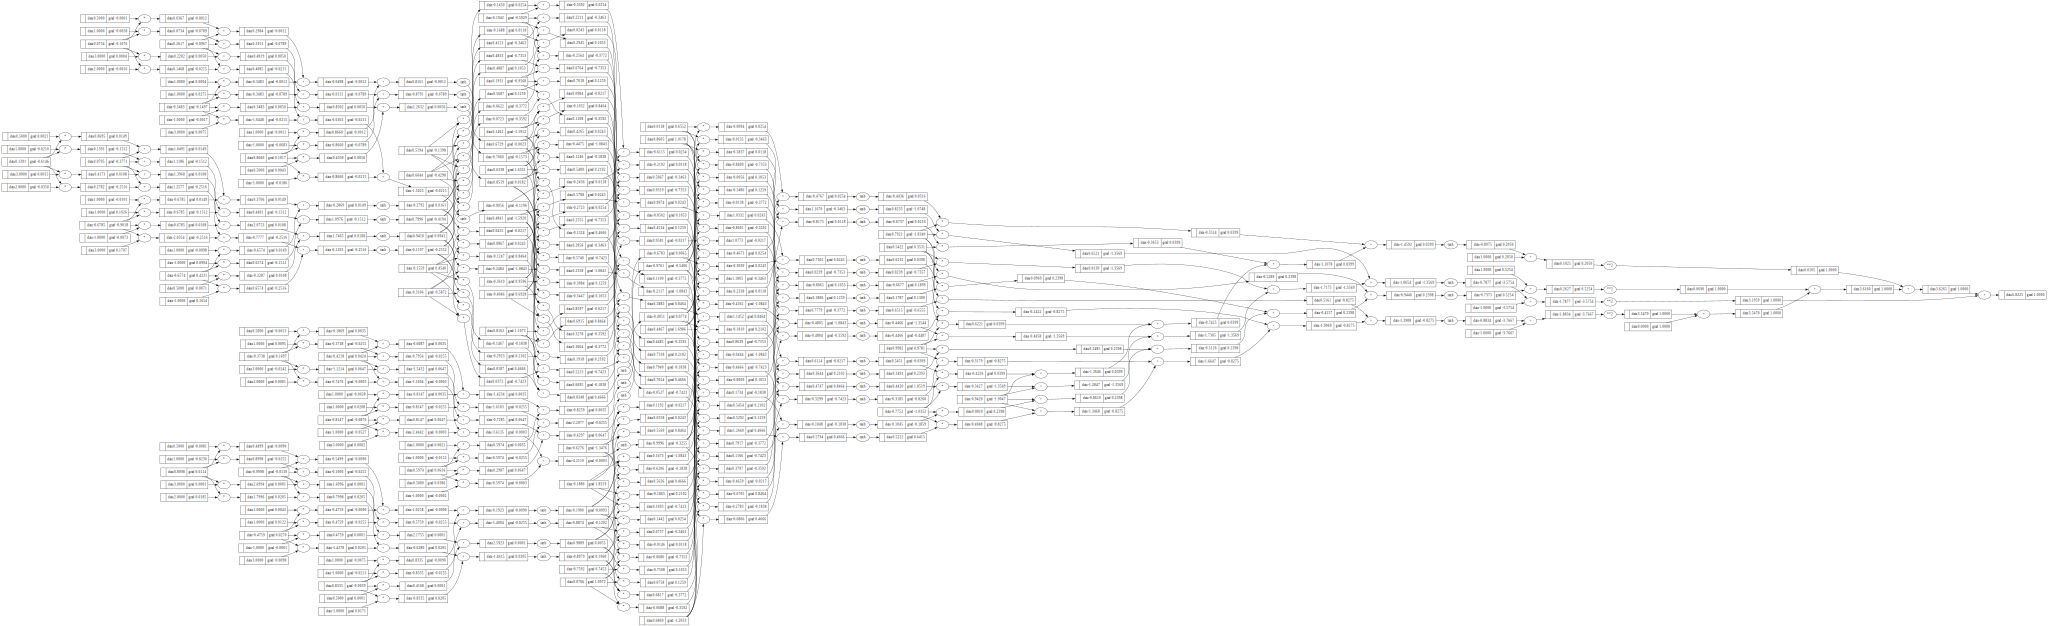

In [20]:
draw_dot(loss)

In [21]:
n.layers[0].neurons[0].w[0].grad

-0.6145662755616497

In [22]:
### Stepping/Update

In [23]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [24]:
n.layers[0].neurons[0].w[0].data

0.14524148419312471

In [28]:
for k in range(20):
    # forward pass
    ypreds = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2) for ygt, yout in zip(ys, ypreds))

    # backward pass
    for p in n.parameters(): p.grad = 0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 6.429205517736047
1 2.131707576298153
2 0.30623165765050553
3 0.10989725170660197
4 0.08335289422675343
5 0.06928749646207628
6 0.06006536459154358
7 0.053342714669496374
8 0.048127848541398385
9 0.04391699294561043
10 0.04042102210711918
11 0.03745887204846447
12 0.03490956774129338
13 0.032688199169206365
14 0.03073284280837782
15 0.028996946814473498
16 0.02744464661138423
17 0.026047748828464334
18 0.02478371403747104
19 0.02363426354836421


In [30]:
ypreds, ys

([value(data=0.9243493286372974),
  value(data=-0.9249675723027001),
  value(data=-0.9151115144610974),
  value(data=0.9287587248324571)],
 [1.0, -1.0, -1.0, 1.0])